<h1 style-"font-size:3rem; color:black;">Static Hand Gesture Recognition using CNN</h1>
<p>By: Nur Farzanah Roslan <br>

### Introduction
This project is the research project for the Master of Data Science programme.

### Background
- Communication started from verbal communication a long time ago during primitive times and since then, it gets evolved into visual communication and written communication (Novak, 2019). 

- **Sign language**: A survey shows that American Sign Language (ASL) is ranked fourth in the most popular foreign languages taken at colleges (Goldberg et al., 2015). 

- **Hand Gesture Recognition (HGR) system**: HGR systems can be categorized into device-based and vision-based, with vision-based modelling approach is said to have better practicality in real-life situation (Mohamed et al., 2021).

- **Convolutional Neural Network (CNN)**: It is one of the most widely used techniques because it can detect important features automatically without the need of human supervisions (Mohamed et al., 2021). 

### Problem Statement
- The **difficulty in communication** is one of the **major barriers** faced by deaf community and can affect their life in an undesired way. 
- Even though they use hand gestures along with facial expressions and body movements to communicate, but not many people learn the sign language and can understand them. 
- This barrier is a major social concern and can be solved using the advanced algorithms in **deep learning** such as convolutional neural network (CNN). 
- However, this learning is heavily reliant on large amount of the training data to avoid overfitting, and **current dataset that we have is small in size**. 
- One of the ways to deal with this problem is using **data augmentation**. 

### Research Objectives
1. To propose a static hand gesture recognition system using convolutional neural network (CNN).
2. To demonstrate the optimal static hand gesture recognition using various data augmentation techniques. 
3. To evaluate the performance of the proposed static hand gesture recognition system. 

### Research Questions
1. What is the deep learning architecture that can classify the static hand gesture?  
2. How to demonstrate the optimal static hand gesture recognition using various data augmentation techniques? 
3. Does the proposed static hand gesture recognition system perform better than other available hand gesture recognition system?

### Data Source
This project uses a public sign language dataset from **Massey University**, called MU HandImages ASL dataset, which has:
   - a total of 2515 images with 36 classes
   - Consists of 5 subjects

### Data Preparation
This project uses Python libraries to perform all processes. The data preparation includes the process of augmenting & renaming the dataset.

<p><img src = "methodology_figure.png"></p>

Specifically, we will be implementing **TensorFlow Keras, Pillow libraries** for augmenting our data, creating our model & training it. We will also use **Matplotlib** for visualizing our dataset to get better understanding of the images we are going to be handling. 

#### Importing dependencies

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image \
    import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from imutils import paths
import random
import shutil
import logging
import os
import config
import cv2

np.random.seed(8)
tf.get_logger().setLevel(logging.ERROR) # set logging level only to print out error while suppressing warnings
tf.random.set_seed(8) # TF has its own random seed that needs to be set to get reproducible results

#### Importing the dataset
The dataset is downloaded & stored at my local system. The directory is shown as follows: 
![orig_input_dataset.png](orig_input_dataset.png)

In [16]:
# grab the paths to all input in the original input directory
img_paths = list(paths.list_images(config.ORIG_INPUT_DATASET))

There is **an imbalanced class**, where class 't' has only 65 images in total compared to others which has 70 images in total. To handle this imbalanced class, we inspected the original images from class 't' and found out that the class missed 5 images with diffuse illumination ('diff') condition. Since it is only 5 images, we **manually add new images** by varying the exposure of its original images using Adobe Photoshop.

#### Preparing the dataset
This phase prepares dataset to load to Keras library. In order to load to Keras library, the directory structure should be as follows:

![keras_directory.png](keras_directory.png)

Since our dataset directory is organized by subject-based, instead of class-based, so, we need to organize our images accordingly. Our expected directory is as follows:
![new_input_dir.png](new_input_dir.png)

- For **signer-dependent**, all images will be randomly split to a ratio of 70:30 for training & testing later.
- For **signer-independent**, images from 4 subjects (Subject 1 - 4) are selected as training set, and 1 (Subject 5) subject for testing.

In [17]:
# compute the training and testing split
paths_sd = img_paths[:]
train_paths_si = [x for x in img_paths if x.startswith((config.TRAIN_SPLIT_SI_1, config.TRAIN_SPLIT_SI_2, config.TRAIN_SPLIT_SI_3, config.TRAIN_SPLIT_SI_4))]
test_paths_si = [x for x in img_paths if x.startswith(config.TEST_SPLIT_SI)]

# define the datasets that will be built
datasets = [
    ("signer-dependent", "all", paths_sd, config.PATH_SD),
    ("signer-independent", "training", train_paths_si, config.TRAIN_PATH_SI),
    ("signer-independent", "testing", test_paths_si, config.TEST_PATH_SI)
]

# loop over the datasets
for (signer_type, d_type, img_paths, base_output) in datasets:
    # show which data split which are created
    print("[INFO] Building '{}' data for {}".format(d_type, signer_type))

    # if the output base outputs directory does not exit, create it
    if not os.path.exists(base_output):
        print("[INFO] 'Creating {}' directory".format(base_output))
        os.makedirs(base_output)
    
    # loop over the input image paths
    for input_path in img_paths:
        # extract the filename of the input image and extract the class label
        file_name = input_path.split(os.path.sep)[-1]
        label = file_name.split("_")[1]
    
        # build the path to the label directory
        label_path = os.path.sep.join([base_output,label])

        # if the label output directory does not exist, create it
        if not os.path.exists(label_path):
            print("[INFO] 'Creating {}' directory".format(label_path))
            os.makedirs(label_path)
    
        # construct the path to the destination image and then copy the image itself
        p = os.path.sep.join([label_path, file_name])
        shutil.copy2(input_path, p)

print('[INFO] SIGNER-DEPENDENT(SD)\t: There are {} images for training & testing'.format(len(paths_sd)))
print('[INFO] SIGNER-INDEPENDENT(SI)\t: There are {} images for training & {} images for testing'.format(len(train_paths_si), len(test_paths_si)))

[INFO] Building 'all' data for signer-dependent
[INFO] Building 'training' data for signer-independent
[INFO] Building 'testing' data for signer-independent
[INFO] SIGNER-DEPENDENT(SD)	: There are 2520 images for training & testing
[INFO] SIGNER-INDEPENDENT(SI)	: There are 2160 images for training & 360 images for testing


In [18]:
# Inspecting the directory & number of dataset in the directory
def list_files(file_path):
    for root, dirs, files in os.walk(file_path):
        level = root.replace(file_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        count = 0
        for f in files:
            count += 1
        print('{}{}/\t[{} files]'.format(indent, os.path.basename(root), count))
print('[INFO] Before: ')
list_files(config.ORIG_INPUT_DATASET)
print('\n\n[INFO] After: ')
list_files(config.BASE_PATH_SD)
list_files(config.BASE_PATH_SI)

[INFO] Before: 
orig/	[0 files]
    hand1/	[900 files]
    hand2/	[900 files]
    hand3/	[180 files]
    hand4/	[180 files]
    hand5/	[360 files]


[INFO] After: 
signer_dependent/	[0 files]
    all/	[0 files]
        0/	[70 files]
        1/	[70 files]
        2/	[70 files]
        3/	[70 files]
        4/	[70 files]
        5/	[70 files]
        6/	[70 files]
        7/	[70 files]
        8/	[70 files]
        9/	[70 files]
        a/	[70 files]
        b/	[70 files]
        c/	[70 files]
        d/	[70 files]
        e/	[70 files]
        f/	[70 files]
        g/	[70 files]
        h/	[70 files]
        i/	[70 files]
        j/	[70 files]
        k/	[70 files]
        l/	[70 files]
        m/	[70 files]
        n/	[70 files]
        o/	[70 files]
        p/	[70 files]
        q/	[70 files]
        r/	[70 files]
        s/	[70 files]
        t/	[70 files]
        u/	[70 files]
        v/	[70 files]
        w/	[70 files]
        x/	[70 files]
        y/	[70 files]
        z/	[70 file

### Data Augmentation
The techniques & configurations for augmenting the data will be implemented as the following:
![technique_augment.png](technique_augment.png)

#### Inspecting image in its original size

In [19]:
def display_image_in_actual_size(im_path):
    dpi = 100
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)
    # Create a figure of the right size with one axis that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    ax.imshow(im_data, cmap='gray')
    plt.show()

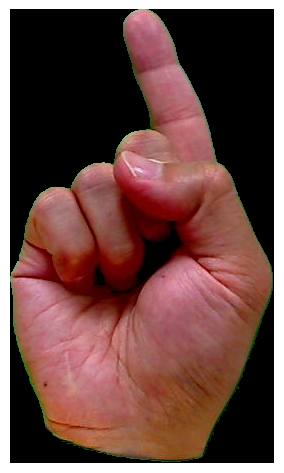

In [20]:
# Display a sample image
IMAGE_PATH = config.TEST_PATH_SI + '\\1\\hand5_1_bot_seg_1_cropped.png'
display_image_in_actual_size(IMAGE_PATH)

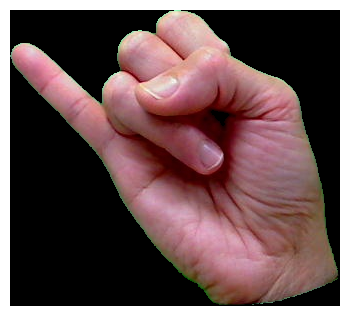

In [21]:
# Display a different sample image
IMAGE_PATH = config.TRAIN_PATH_SI + '\\j\\hand1_j_top_seg_1_cropped.png'
display_image_in_actual_size(IMAGE_PATH)

Clearly, the dimensions and aspect ratios of these images are different.

#### Transforming images to fix specification

In [22]:
# Define keyword arguments
BATCH_SIZE = 32
EPOCHS = 150
IMG_HEIGHT = 128
IMG_WIDTH = 128
MIN_BRIGHTNESS = 0.3
MAX_BRIGHTNESS = 0.7
MAX_ANGLE = 10

# Define custom augmentation function (for contrast, blur, sharpen)
def random_contrast(np_tensor):
    return tf.image.random_contrast(np_tensor, 0.5, 2)
def random_blur(np_tensor):
    return (cv2.blur(np_tensor, (10, 10)))
def random_sharpen(np_tensor):
    kernel = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])
    return cv2.filter2D(src = np_tensor, ddepth = -1, kernel = kernel)

# No data augmentation
# datagen_kwargs = dict(rescale = 1./255, validation_split = 0.3)

# Single data augmentation - geometric transformations
# datagen_kwargs = dict(rescale = 1./255,
#                       validation_split = 0.3, 
#                       rotation_range = MAX_ANGLE,
#                       horizontal_flip = True,
#                       fill_mode = 'nearest',
#                       preprocessing_function = None)

# Single data augmentation - color space transformations (brightness & contrast)
def custom_augmentation(np_tensor):
    augmented_tensor = random_contrast(np_tensor)
    return np.array(augmented_tensor)     
datagen_kwargs = dict(rescale = 1./255,
                      validation_split = 0.3,
                      brightness_range = [MIN_BRIGHTNESS, MAX_BRIGHTNESS],
                      preprocessing_function = custom_augmentation) 

# Single data augmentation - kernel filters (blur & sharpen)
# def custom_augmentation(np_tensor):
#     augmented_tensor = random_blur(np_tensor)
#     augmented_tensor = random_sharpen(augmented_tensor)
#     return np.array(augmented_tensor)
# datagen_kwargs = dict(rescale = 1./255,
#                       validation_split = 0.3,
#                       preprocessing_function = custom_augmentation) 

# Multiple data augmentation - geometric + color space transformations
# def custom_augmentation(np_tensor):
#     augmented_tensor = random_contrast(np_tensor)
#     return np.array(augmented_tensor)  
# datagen_kwargs = dict(rescale = 1./255,
#                       validation_split = 0.3, 
#                       rotation_range = MAX_ANGLE,
#                       horizontal_flip = True,
#                       brightness_range = [MIN_BRIGHTNESS, MAX_BRIGHTNESS],
#                       fill_mode = 'nearest',
#                       preprocessing_function = custom_augmentation)

# Multiple data augmentation - geometric transformations + kernel filters
# def custom_augmentation(np_tensor):
#     augmented_tensor = random_blur(np_tensor)
#     augmented_tensor = random_sharpen(augmented_tensor)
#     return np.array(augmented_tensor)
# datagen_kwargs = dict(rescale = 1./255,
#                       validation_split = 0.3, 
#                       rotation_range = MAX_ANGLE,
#                       horizontal_flip = True,
#                       fill_mode = 'nearest',
#                       preprocessing_function = custom_augmentation)

# Multiple data augmentation - color space transformations + kernel filter
# def custom_augmentation(np_tensor):
#     augmented_tensor = np.array(random_contrast(np_tensor))
#     augmented_tensor = random_blur(augmented_tensor)
#     augmented_tensor = random_sharpen(augmented_tensor)
#     return np.array(augmented_tensor)
# datagen_kwargs = dict(rescale = 1./255,
#                       validation_split = 0.3,
#                       brightness_range = [MIN_BRIGHTNESS, MAX_BRIGHTNESS],
#                       preprocessing_function = custom_augmentation) 

# Multiple data augmentation - all three
# def custom_augmentation(np_tensor):
#     augmented_tensor = np.array(random_contrast(np_tensor))
#     augmented_tensor = random_blur(augmented_tensor)
#     augmented_tensor = random_sharpen(augmented_tensor)
#     return np.array(augmented_tensor)
# datagen_kwargs = dict(rescale = 1./255,
#                       validation_split = 0.3, 
#                       rotation_range = 90,
#                       horizontal_flip = True,
#                       brightness_range = [0.3, 0.7],
#                       fill_mode = 'nearest',
#                       preprocessing_function = custom_augmentation)


dataflow_kwargs = dict(batch_size = BATCH_SIZE,\
                  target_size = (IMG_HEIGHT, IMG_WIDTH),\
                  class_mode = 'categorical')

**PART A: Signer Dependent**

In [23]:
# training the image
print('========== TRAINING =========')
train_image_generator = ImageDataGenerator(**datagen_kwargs)
train_data_gen = train_image_generator.flow_from_directory\
                  (directory = config.PATH_SD,\
                  shuffle = True,\
                  subset = 'training',
                  **dataflow_kwargs)
#Inspect the output of the generator
for image_batch, labels_batch in train_data_gen:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

# Validating the images
print('========= VALIDATING =========')
valid_image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.3)
valid_data_gen = valid_image_generator.flow_from_directory\
                  (directory = config.PATH_SD,\
                  shuffle = False,\
                  subset = 'validation',
                  **dataflow_kwargs)
#Inspect the output of the generator
for image_batch, labels_batch in valid_data_gen:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

========== TRAINING =========
Found 1764 images belonging to 36 classes.
(32, 128, 128, 3)
(32, 36)
========= VALIDATING =========
Found 756 images belonging to 36 classes.
(32, 128, 128, 3)
(32, 36)


The output consists of NumPy arrays. The sample size for a batch of images is 32, with a height and width of 224 pixels and three channels representing RGB color space.

Similar to the label batch, there are 32 samples. Each row is encoded with one hot bit to indicate which of the five classes it belongs to. Retrieve the lookup dictionary of labels is another essential step. 

#### Labelling & inspecting new dataset

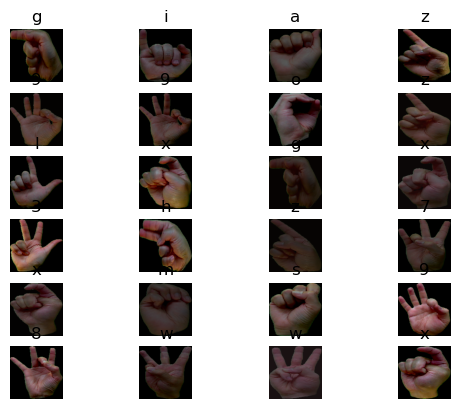

In [24]:
# label the image
labels_idx = (train_data_gen.class_indices)
train_labels = dict((v,k) for k,v in labels_idx.items())
labels_idy = (valid_data_gen.class_indices)
valid_labels = dict((v,k) for k,v in labels_idx.items())

# Inspect new augmented dataset
image_batch, label_batch = next(iter(train_data_gen))
fig, axes = plt.subplots(6, 4)
axes = axes.flatten()

for img, lbl, ax in zip(image_batch, label_batch, axes):
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    label_ = np.argmax(lbl)    
    label = train_labels[label_]
    ax.set_title(label)
    ax.axis('off')
plt.show()

### Data Modelling

#### Define the configuration

In [25]:
# Model with two convolutional and one fully connected layer.
# model1 = Sequential(name="CNN_Conf1")
# model1.add(Conv2D(64, (5, 5), strides=(2,2),
#                  activation='relu', padding='same',
#                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#                  kernel_initializer='he_normal',
#                  bias_initializer='zeros'))
# model1.add(Conv2D(64, (3, 3), strides=(2,2),
#                  activation='relu', padding='same',
#                  kernel_initializer='he_normal',
#                  bias_initializer='zeros'))
# model1.add(Flatten())
# model1.add(Dense(36, activation='softmax',
#                 kernel_initializer='glorot_uniform',
#                 bias_initializer='zeros'))
# Use Adam optimizer with default parameters.
# Categorical cross-entropy as loss function and
# report accuracy during training.
# model1.compile(loss='categorical_crossentropy',
#               optimizer='adam', metrics =['accuracy'])
# model1.summary()

# Model Configuration 2
# model2 = Sequential(name="CNN_Conf2")
# model2.add(Conv2D(64, (3, 3), strides=(2,2),
#                  activation='relu', padding='same',
#                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#                  kernel_initializer='he_normal',
#                  bias_initializer='zeros'))
# model2.add(Conv2D(16, (2, 2), strides=(2,2),
#                  activation='relu', padding='same',
#                  kernel_initializer='he_normal',
#                  bias_initializer='zeros'))
# model2.add(Flatten())
# model2.add(Dense(36, activation='softmax',
#                 kernel_initializer='glorot_uniform',
#                 bias_initializer='zeros'))
# Use Adam optimizer with default parameters.
# Categorical cross-entropy as loss function and
# report accuracy during training.
# model2.compile(loss='categorical_crossentropy',
#               optimizer='adam', metrics =['accuracy'])
# model2.summary()

# Model Configuration 3
# model3 = Sequential(name="CNN_Conf3")
# model3.add(Conv2D(64, (3, 3), strides=(2,2),
#                  activation='relu', padding='same',
#                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#                  kernel_initializer='he_normal',
#                  bias_initializer='zeros'))
# model3.add(Dropout(0.2))
# model3.add(Conv2D(16, (2, 2), strides=(2,2),
#                  activation='relu', padding='same',
#                  kernel_initializer='he_normal',
#                  bias_initializer='zeros'))
# model3.add(Dropout(0.2))
# model3.add(Flatten())
# model3.add(Dense(36, activation='softmax',
#                 kernel_initializer='glorot_uniform',
#                 bias_initializer='zeros'))
# Use Adam optimizer with default parameters.
# Categorical cross-entropy as loss function and
# report accuracy during training.
# model3.compile(loss='categorical_crossentropy',
#               optimizer='adam', metrics =['accuracy'])
# model3.summary()

# Model Configuration 4
# model4 = Sequential(name="CNN_Conf4")
# model4.add(Conv2D(64, (4, 4), activation='relu', padding='same',
#                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# model4.add(Dropout(0.2))
# model4.add(Conv2D(64, (2, 2), activation='relu', padding='same',
#                  strides=(2,2)))
# model4.add(Dropout(0.2))
# model4.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# model4.add(Dropout(0.2))
# model4.add(Flatten())
# model4.add(Dense(64, activation='relu'))
# model4.add(Dropout(0.2))
# model4.add(Dense(36, activation='softmax'))

# model4.compile(loss='categorical_crossentropy', 
#               optimizer='adam', metrics =['accuracy'])
# model4.summary()

# # Model Configuration 5
model5 = Sequential(name="CNN_Conf5")
model5.add(Conv2D(64, (4, 4), activation='relu', padding='same',
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.2))
model5.add(Conv2D(64, (2, 2), activation='relu', padding='same',
                 strides=(2,2)))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.2))
model5.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.2))
model5.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.2))
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(36, activation='softmax'))


model5.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics =['accuracy'])
model5.summary()

# # Model Configuration 6
# model6 = Sequential(name="CNN_Conf6")
# model6.add(Conv2D(64, (4, 4), activation='tanh', padding='same',
#                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# model6.add(Dropout(0.2))
# model6.add(Conv2D(64, (2, 2), activation='tanh', padding='same',
#                  strides=(2,2)))
# model6.add(Dropout(0.2))
# model6.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
# model6.add(Dropout(0.2))
# model6.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
# model6.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# model6.add(Dropout(0.2))
# model6.add(Flatten())
# model6.add(Dense(64, activation='tanh'))
# model6.add(Dropout(0.2))
# model6.add(Dense(64, activation='tanh'))
# model6.add(Dropout(0.2))
# model6.add(Dense(36, activation='softmax'))

# model6.compile(loss='mean_squared_error', 
#               optimizer='adam', metrics =['accuracy'])
# model6.summary()

Model: "CNN_Conf5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        16448     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 64)        0 

### Training the network

We are now ready to train the network by calling fit() on the model.

In [26]:
# history1 = model1.fit(train_data_gen,
#             validation_data=valid_data_gen,
#             epochs=EPOCHS, batch_size=BATCH_SIZE,
#             verbose=2, shuffle=True)

# history2 = model2.fit(train_data_gen,
#             validation_data=valid_data_gen,
#             epochs=EPOCHS, batch_size=BATCH_SIZE,
#             verbose=2, shuffle=True)

# history3 = model3.fit(train_data_gen,
#             validation_data=valid_data_gen,
#             epochs=EPOCHS, batch_size=BATCH_SIZE,
#             verbose=2, shuffle=True)

# history4 = model4.fit(train_data_gen,
#             validation_data=valid_data_gen,
#             epochs=EPOCHS, batch_size=BATCH_SIZE,
#             verbose=2, shuffle=True)

history5 = model5.fit(train_data_gen,
            validation_data=valid_data_gen,
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            verbose=2, shuffle=True)

# history6 = model6.fit(train_data_gen,
#             validation_data=valid_data_gen,
#             epochs=EPOCHS, batch_size=BATCH_SIZE,
#             verbose=2, shuffle=True)


Epoch 1/150
56/56 - 64s - loss: 3.5859 - accuracy: 0.0289 - val_loss: 3.5717 - val_accuracy: 0.0476 - 64s/epoch - 1s/step
Epoch 2/150
56/56 - 46s - loss: 3.4926 - accuracy: 0.0590 - val_loss: 3.0671 - val_accuracy: 0.2090 - 46s/epoch - 814ms/step
Epoch 3/150
56/56 - 45s - loss: 2.7880 - accuracy: 0.2330 - val_loss: 1.6291 - val_accuracy: 0.5251 - 45s/epoch - 796ms/step
Epoch 4/150
56/56 - 45s - loss: 2.0533 - accuracy: 0.3861 - val_loss: 0.8359 - val_accuracy: 0.7103 - 45s/epoch - 797ms/step
Epoch 5/150
56/56 - 46s - loss: 1.5555 - accuracy: 0.5125 - val_loss: 0.6675 - val_accuracy: 0.7593 - 46s/epoch - 820ms/step
Epoch 6/150
56/56 - 47s - loss: 1.2709 - accuracy: 0.5930 - val_loss: 0.5189 - val_accuracy: 0.7910 - 47s/epoch - 837ms/step
Epoch 7/150
56/56 - 50s - loss: 1.0877 - accuracy: 0.6440 - val_loss: 0.4181 - val_accuracy: 0.8347 - 50s/epoch - 896ms/step
Epoch 8/150
56/56 - 56s - loss: 0.9280 - accuracy: 0.6808 - val_loss: 0.4696 - val_accuracy: 0.8228 - 56s/epoch - 1s/step
Epoch 

Epoch 67/150
56/56 - 159s - loss: 0.1641 - accuracy: 0.9478 - val_loss: 0.2651 - val_accuracy: 0.9299 - 159s/epoch - 3s/step
Epoch 68/150
56/56 - 161s - loss: 0.1169 - accuracy: 0.9609 - val_loss: 0.3096 - val_accuracy: 0.9299 - 161s/epoch - 3s/step
Epoch 69/150
56/56 - 161s - loss: 0.1186 - accuracy: 0.9603 - val_loss: 0.2482 - val_accuracy: 0.9352 - 161s/epoch - 3s/step
Epoch 70/150
56/56 - 165s - loss: 0.1163 - accuracy: 0.9541 - val_loss: 0.2497 - val_accuracy: 0.9233 - 165s/epoch - 3s/step
Epoch 71/150
56/56 - 166s - loss: 0.1419 - accuracy: 0.9546 - val_loss: 0.3118 - val_accuracy: 0.9339 - 166s/epoch - 3s/step
Epoch 72/150
56/56 - 170s - loss: 0.1039 - accuracy: 0.9666 - val_loss: 0.3709 - val_accuracy: 0.9114 - 170s/epoch - 3s/step
Epoch 73/150
56/56 - 168s - loss: 0.1227 - accuracy: 0.9569 - val_loss: 0.3240 - val_accuracy: 0.9153 - 168s/epoch - 3s/step
Epoch 74/150
56/56 - 168s - loss: 0.1032 - accuracy: 0.9649 - val_loss: 0.3348 - val_accuracy: 0.9233 - 168s/epoch - 3s/step


Epoch 133/150
56/56 - 275s - loss: 0.0938 - accuracy: 0.9756 - val_loss: 0.3711 - val_accuracy: 0.9220 - 275s/epoch - 5s/step
Epoch 134/150
56/56 - 280s - loss: 0.0741 - accuracy: 0.9779 - val_loss: 0.3004 - val_accuracy: 0.9233 - 280s/epoch - 5s/step
Epoch 135/150
56/56 - 285s - loss: 0.0661 - accuracy: 0.9790 - val_loss: 0.4496 - val_accuracy: 0.9101 - 285s/epoch - 5s/step
Epoch 136/150
56/56 - 290s - loss: 0.0792 - accuracy: 0.9756 - val_loss: 0.3847 - val_accuracy: 0.9167 - 290s/epoch - 5s/step
Epoch 137/150
56/56 - 295s - loss: 0.0702 - accuracy: 0.9762 - val_loss: 0.3535 - val_accuracy: 0.9193 - 295s/epoch - 5s/step
Epoch 138/150
56/56 - 324s - loss: 0.0736 - accuracy: 0.9790 - val_loss: 0.3557 - val_accuracy: 0.9127 - 324s/epoch - 6s/step
Epoch 139/150
56/56 - 348s - loss: 0.0781 - accuracy: 0.9785 - val_loss: 0.3655 - val_accuracy: 0.9153 - 348s/epoch - 6s/step
Epoch 140/150
56/56 - 334s - loss: 0.0658 - accuracy: 0.9785 - val_loss: 0.3928 - val_accuracy: 0.9352 - 334s/epoch - 

56/56 - 188s - loss: 0.0022 - accuracy: 1.0000 - 188s/epoch - 3s/step
24/24 - 43s - loss: 0.3923 - accuracy: 0.9220 - 43s/epoch - 2s/step
The training accuracy of Model 5: 1.0
The testing accuracy of Model 5: 0.9219576716423035


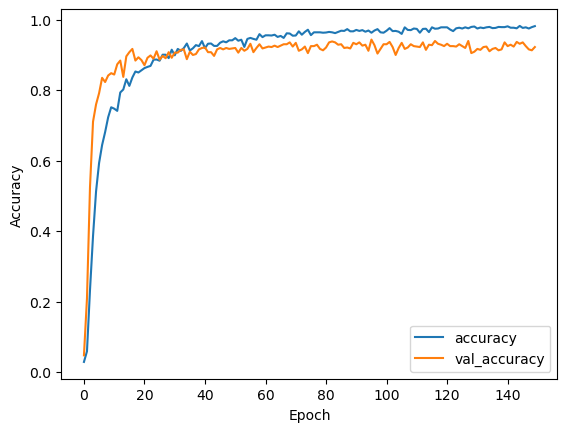

In [27]:
# # plotting Model 1
# plt.plot(history1.history['accuracy'], label='accuracy')
# plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# train_loss, train_acc = model1.evaluate(train_data_gen, verbose=2)
# test_loss, test_acc = model1.evaluate(valid_data_gen, verbose=2)
# print("The training accuracy of Model 1:", train_acc)
# print("The testing accuracy of Model 1:", test_acc)

# # plotting Model 2
# plt.plot(history2.history['accuracy'], label='accuracy')
# plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# train_loss, train_acc = model2.evaluate(train_data_gen, verbose=2)
# test_loss, test_acc = model2.evaluate(valid_data_gen, verbose=2)
# print("The training accuracy of Model 2:", train_acc)
# print("The testing accuracy of Model 2:", test_acc)

# # plotting Model 3
# plt.plot(history3.history['accuracy'], label='accuracy')
# plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# train_loss, train_acc = model3.evaluate(train_data_gen, verbose=2)
# test_loss, test_acc = model3.evaluate(valid_data_gen, verbose=2)
# print("The training accuracy of Model 3:", train_acc)
# print("The testing accuracy of Model 3:", test_acc)

# plotting Model 4
# plt.plot(history4.history['accuracy'], label='accuracy')
# plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# train_loss, train_acc = model4.evaluate(train_data_gen, verbose=2)
# test_loss, test_acc = model4.evaluate(valid_data_gen, verbose=2)
# print("The training accuracy of Model 4:", train_acc)
# print("The testing accuracy of Model 4:", test_acc)

# plotting Model 5
plt.plot(history5.history['accuracy'], label='accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
train_loss, train_acc = model5.evaluate(train_data_gen, verbose=2)
test_loss, test_acc = model5.evaluate(valid_data_gen, verbose=2)
print("The training accuracy of Model 5:", train_acc)
print("The testing accuracy of Model 5:", test_acc)

# # plotting Model 6
# plt.plot(history6.history['accuracy'], label='accuracy')
# plt.plot(history6.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# train_loss, train_acc = model6.evaluate(train_data_gen, verbose=2)
# test_loss, test_acc = model6.evaluate(valid_data_gen, verbose=2)
# print("The training accuracy of Model 6:", train_acc)
# print("The testing accuracy of Model 6:", test_acc)

The training loss of Model 5: 0.002188874874264002
The testing loss of Model 5: 0.3922867178916931


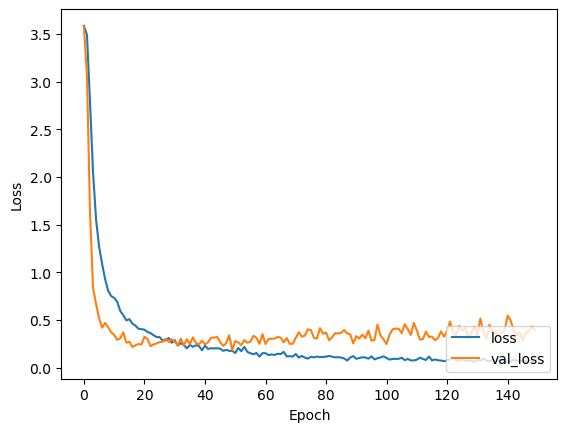

In [28]:
# plotting Model 1
# plt.plot(history1.history['loss'], label='loss')
# plt.plot(history1.history['val_loss'], label = 'val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(loc='lower right')
# print("The train loss of Model 1:", train_loss)
# print("The testing loss of Model 1:", test_loss)

# plotting Model 2
# plt.plot(history2.history['loss'], label='loss')
# plt.plot(history2.history['val_loss'], label = 'val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(loc='lower right')
# print("The train loss of Model 2:", train_loss)
# print("The testing loss of Model 2:", test_loss)

# plotting Model 3
# plt.plot(history3.history['loss'], label='loss')
# plt.plot(history3.history['val_loss'], label = 'val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(loc='lower right')
# print("The train loss of Model 3:", train_loss)
# print("The testing loss of Model 3:", test_loss)

# plotting Model 4
# plt.plot(history4.history['loss'], label='loss')
# plt.plot(history4.history['val_loss'], label = 'val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(loc='lower right')
# print("The training loss of Model 4:", train_loss)
# print("The testing loss of Model 4:", test_loss)

# plotting Model 5
plt.plot(history5.history['loss'], label='loss')
plt.plot(history5.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
print("The training loss of Model 5:", train_loss)
print("The testing loss of Model 5:", test_loss)

# plotting Model 6
# plt.plot(history6.history['loss'], label='loss')
# plt.plot(history6.history['val_loss'], label = 'val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(loc='lower right')
# print("The train loss of Model 6:", train_loss)
# print("The testing loss of Model 6:", test_loss)